In [31]:
# !cat /usr/local/cuda/version.txt
# !apt install libnvrtc9.1
# !pip install mxnet-cu100

In [32]:
import os
#from google.colab import drive
import torchvision.datasets as datasets
import torchvision
import torch
import numpy as np
import cv2
#import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as tfs
import torchvision.models as models
from torch.utils.data.dataset import Dataset 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from mxnet import  image
import torchvision.transforms.functional as TF
import mxnet
import datetime
from  datetime import datetime
from torch.autograd import Variable

In [33]:
path='.'
def read_images(root=path, train=True):
    txt_fname = root + '/Gatedetection/VOC/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'Gatedetection/VOC/JPEGImages', i+'.png') for i in images]
    label = [os.path.join(root, 'Gatedetection/VOC/SegmentationClass', i+'.png') for i in images]
    return data, label


In [34]:
classes = ['background','gate']

# RGB value for each class
colormap = [[0,0,0],[255,255,255]]
cm2lbl = np.zeros(256**3) # each pixel is an array belong to [0,0,0]~[255,255,255]
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # set an index   
cm2lbl[128]       

0.0

In [35]:
def image2label(im):
    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # get label matrix according to index

*data pre-processing* it need a batch to compute, and the size of pictures should be same. Since there is no way to resize the label effectively and make it match at the pixel level, in order to make the size of the image being same, crop is used here to solve this problem

In [36]:
def rand_crop(data, label, height, width): #crop the image into the same size. crop the same aera in image and label
    '''
    data is PIL.Image object
    label is PIL.Image object
    '''
    data=mxnet.nd.array(data)
    label=mxnet.nd.array(label)
    data, rect =image.random_crop(data,(width, height))
    label = image.fixed_crop(label,*rect)
    data=data.asnumpy()
    label=label.asnumpy()
    return data, label

In [37]:
def img_transforms(im, label, crop_size): #data pre-processing.
    im, label=rand_crop(im, label, *crop_size)
    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #standardize the rgb values with mean and variance of ImageNet
    ])
    
    im = im_tfs(im)
    label = image2label(label)
    return im, label

In [38]:
class GateDataset(torch.utils.data.Dataset):#Define a GataDataset derived from`torch.utils.data.Dataset` to construct self-defined set
    '''
    voc dataset
    '''
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
        
    def _filter(self, images): # filter the pictures whose sizes are smaller than the crop size
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB') 
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [39]:
# instantiate dataset
input_shape = (360, 360)
voc_train = GateDataset(True, input_shape, img_transforms)
voc_test = GateDataset(False, input_shape, img_transforms)

train_data = DataLoader(voc_train, batch_size=8, shuffle=True, num_workers=0)#training batch size, change it for parameter comparison
valid_data = DataLoader(voc_test, batch_size=4, num_workers=0)#validtaion batch size,change it for parameter comparison

Read 220 images
Read 54 images


In [40]:
for data in train_data:
  with torch.no_grad():
    im = Variable(data[0].cuda())
    label = Variable(data[1].cuda())

In [41]:
voc_train[0][1].shape

(360, 360)

In [42]:
def bilinear_kernel(in_channels, out_channels, kernel_size):#bilinear kernel is utilized to calcute the weight of upsample_
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    #print(1 - abs(og[0] - center) / factor)
    #print(1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

In [43]:
# define transposed convolution,upsample_
conv_trans = nn.ConvTranspose2d(in_channels=3,out_channels=3,kernel_size=4,stride=2,padding=1)
# define it as bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)

In [44]:
# use pre-trained resnet 34
#from  mxnet.gluon.model_zoo import vision as models
net = models.resnet34(pretrained=True)
num_classes = len(classes)

In [45]:
#print(net)

In [46]:
list(net.children())[-1]

Linear(in_features=512, out_features=1000, bias=True)

In [47]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(net.children())[:-4]) #remove the last three layers: avgpool and fully connected layers，use list(pretrained_net.children())[:-k] to directly reach the last k-th layer
        self.stage2 = list(net.children())[-4] # second part
        self.stage3 = list(net.children())[-3] # third part
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 2, padding=1)
        self.scores3 = nn.Conv2d(128, num_classes, 2, padding=2)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 16, bias=False)#enlarge the feature map eight times
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # use bilinear kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False) #enlarge the feature map twice  
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # use bilinear kernel

        
    def forward(self, x):
        
        x = self.stage1(x)
        s1 = x # 1/8
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3#23   24
        
        s1 = self.scores3(s1)
        s2 = self.upsample_2x(s2)
        s = s1 + s2#45  48

        s = self.upsample_8x(s)
        return s

In [48]:
#Define some common metrics for semantic segmentation，such as overal accuracy，mean IU 
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [49]:
net = fcn(num_classes)

In [50]:
# define loss and optimizer
#from mxtorch.trainer import ScheduledOptim
#criterion = nn.NLLLoss2d()
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

In [56]:
import time #train the model
import torch.nn.functional as F
for e in range(100):
    
    train_loss = 0
    train_acc = 0
    train_acc_cls = 0
    train_mean_iu = 0
    train_fwavacc = 0
    
    prev_time = time.time()
    net = net.train()
    net=net.cuda()
    for data in train_data:
        with torch.no_grad():
          im = Variable(data[0].cuda())
          label = Variable(data[1].cuda())
          #print(label.shape)
        # forward
        out = net(im) #torch.Size([32, 21, 320, 480])
        #print("out.shape1:",out.shape) 
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        #print("print(out.shape2:",out.shape) 
        loss = criterion(out, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        #print("label_pred.shape:",label_pred.shape) 
        label_true = label.data.cpu().numpy()
        #print("label_true.shape:",label_true.shape) 
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            train_acc += acc
            train_acc_cls += acc_cls
            train_mean_iu += mean_iu
            train_fwavacc += fwavacc
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_acc_cls = 0
    eval_mean_iu = 0
    eval_fwavacc = 0
    for data in valid_data:
        with torch.no_grad():
          im = Variable(data[0].cuda())
          label = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        eval_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            eval_acc += acc
            eval_acc_cls += acc_cls
            eval_mean_iu += mean_iu
            eval_fwavacc += fwavacc
        
    cur_time = time.time()

    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(voc_train), train_mean_iu / len(voc_train),
        eval_loss / len(valid_data), eval_acc / len(voc_test), eval_mean_iu / len(voc_test)))
   
    print(epoch_str)
    print(prev_time)
    print(cur_time)

Epoch: 0, Train Loss: 0.11404, Train Acc: 0.95321, Train Mean IU: 0.75240, Valid Loss: 0.12901, Valid Acc: 0.94800, Valid Mean IU: 0.74715 
1620767428.2886357
1620767434.8975463
Epoch: 1, Train Loss: 0.10622, Train Acc: 0.95747, Train Mean IU: 0.77097, Valid Loss: 0.12046, Valid Acc: 0.95274, Valid Mean IU: 0.77902 
1620767434.897994
1620767441.4399934
Epoch: 2, Train Loss: 0.10042, Train Acc: 0.95992, Train Mean IU: 0.78652, Valid Loss: 0.11625, Valid Acc: 0.95369, Valid Mean IU: 0.77495 
1620767441.4403079
1620767448.0090046
Epoch: 3, Train Loss: 0.09783, Train Acc: 0.96029, Train Mean IU: 0.78957, Valid Loss: 0.11279, Valid Acc: 0.95478, Valid Mean IU: 0.77498 
1620767448.0094078
1620767454.5635855
Epoch: 4, Train Loss: 0.09196, Train Acc: 0.96402, Train Mean IU: 0.80231, Valid Loss: 0.11221, Valid Acc: 0.95459, Valid Mean IU: 0.80832 
1620767454.5643132
1620767461.1109016
Epoch: 5, Train Loss: 0.08751, Train Acc: 0.96562, Train Mean IU: 0.81690, Valid Loss: 0.10337, Valid Acc: 0.95

In [57]:
torch.save(net.state_dict(),'fcn_resnet34.pth')

In [58]:
net.load_state_dict(torch.load('fcn_resnet34.pth'))
net=net.cuda()

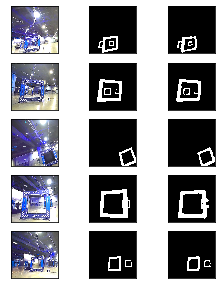

In [59]:
# define prediction function
cm = np.array(colormap).astype('uint8')

def predict(im, label): # prediction result
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()#return the index of each column's maximum element
    pred = cm[pred]
    return pred, cm[label]

#plt figures from any order by changing a,b
_, figs = plt.subplots(5, 3, figsize=(4, 5))  #6=b-a

for i in range(10,15):#(a,b)
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i-10, 0].imshow(Image.open(voc_test.data_list[i]))#10=a
    i=i-10 #10=a
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
plt.savefig('1.png')

In [60]:
maxnum = len(voc_test)
print(maxnum)
for i in range(maxnum):
    test_data, test_label = voc_test[i]
    starttime = datetime.now()
    pred, label = predict(test_data, test_label)
    endtime = datetime.now()
    print('image %s/54 cost (%s)seconds' % (i,(endtime - starttime) ))#print processing time on each image from dataset
    im=Image.fromarray(label)
    im.save('label/label_%s.png' % (i))
    im=Image.fromarray(pred)
    im.save('pre/pre_%s.png' % (i)) #save the predicted label to pre folder. create new folder to save prediction from new paramters

54
image 0/54 cost (0:00:00.017564)seconds
image 1/54 cost (0:00:00.011734)seconds
image 2/54 cost (0:00:00.011152)seconds
image 3/54 cost (0:00:00.011513)seconds
image 4/54 cost (0:00:00.015208)seconds
image 5/54 cost (0:00:00.012506)seconds
image 6/54 cost (0:00:00.011489)seconds
image 7/54 cost (0:00:00.011479)seconds
image 8/54 cost (0:00:00.012914)seconds
image 9/54 cost (0:00:00.011441)seconds
image 10/54 cost (0:00:00.011458)seconds
image 11/54 cost (0:00:00.010873)seconds
image 12/54 cost (0:00:00.011730)seconds
image 13/54 cost (0:00:00.015257)seconds
image 14/54 cost (0:00:00.013722)seconds
image 15/54 cost (0:00:00.011880)seconds
image 16/54 cost (0:00:00.011005)seconds
image 17/54 cost (0:00:00.013230)seconds
image 18/54 cost (0:00:00.014169)seconds
image 19/54 cost (0:00:00.011864)seconds
image 20/54 cost (0:00:00.014506)seconds
image 21/54 cost (0:00:00.011702)seconds
image 22/54 cost (0:00:00.010818)seconds
image 23/54 cost (0:00:00.014695)seconds
image 24/54 cost (0:00: